# Refactorized TDD

In [1]:
import importlib
import numpy as np
import time
import random
from qiskit import QuantumCircuit
import torch

import tdd
from tdd import CUDAcpl


# DEVICE : cpu



## Demonstrating TDD

Hellow world from tdd

[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]


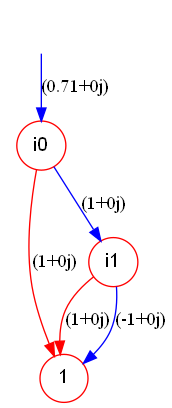

In [2]:
U = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U_tdd = tdd.as_tensor(U)

print(U_tdd.numpy())
U_tdd.show()

### TDD created with different index orders

#### 1. original order

[[[[ 0.5+0.j  0.5+0.j]
   [ 0.5+0.j  0.5+0.j]]

  [[ 0.5+0.j -0.5+0.j]
   [ 0.5+0.j -0.5+0.j]]]


 [[[ 0.5+0.j  0.5+0.j]
   [-0.5+0.j -0.5+0.j]]

  [[ 0.5+0.j -0.5+0.j]
   [-0.5+0.j  0.5+0.j]]]]


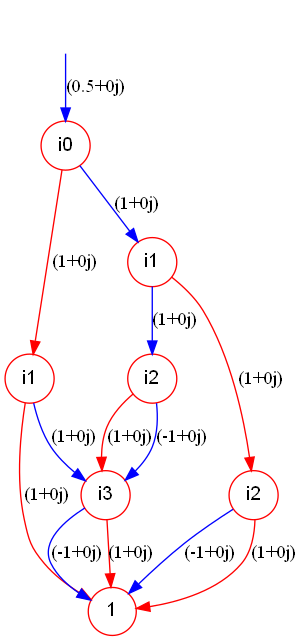

In [3]:
U = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U_tensor = np.einsum('ab,cd->acbd', U, U)
U_tdd = tdd.as_tensor((U_tensor,[],[0,1,2,3]))

print(U_tdd.numpy())
U_tdd.show()

#### 2. rearranged order

[[[[ 0.5+0.j  0.5+0.j]
   [ 0.5+0.j  0.5+0.j]]

  [[ 0.5+0.j -0.5+0.j]
   [ 0.5+0.j -0.5+0.j]]]


 [[[ 0.5+0.j  0.5+0.j]
   [-0.5+0.j -0.5+0.j]]

  [[ 0.5+0.j -0.5+0.j]
   [-0.5+0.j  0.5+0.j]]]]


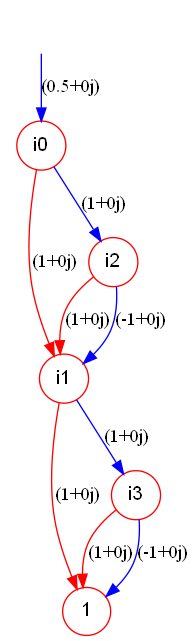

In [4]:
U = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U_tensor = np.einsum('ab,cd->acbd', U, U)
U_tdd = tdd.as_tensor((U_tensor,[],[0,2,1,3]))

print(U_tdd.numpy())
U_tdd.show()

### Parallel storage and calculation

#### storage without parallelization

[[[ 0.70710678+0.j  0.70710678+0.j]
  [ 0.70710678+0.j -0.70710678+0.j]]

 [[ 0.70710678+0.j  0.70710678+0.j]
  [-0.70710678+0.j  0.70710678+0.j]]]


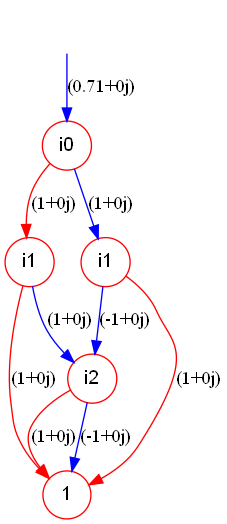

In [5]:
U = 1/np.sqrt(2)*np.array([[[1,1],[1,-1]],[[1,1],[-1,1]]])
U_tdd = tdd.as_tensor((U,[],[]))

print(U_tdd.numpy())
U_tdd.show()

#### storage with parallelization

[[[ 0.70710678+0.j  0.70710678+0.j]
  [ 0.70710678+0.j -0.70710678+0.j]]

 [[ 0.70710678+0.j  0.70710678+0.j]
  [-0.70710678+0.j  0.70710678+0.j]]]


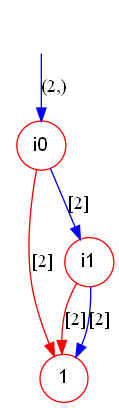

In [6]:
U = 1/np.sqrt(2)*np.array([[[1,1],[1,-1]],[[1,1],[-1,1]]])
U_tdd = tdd.as_tensor((U,[2],[]))

print(U_tdd.numpy())
U_tdd.show()

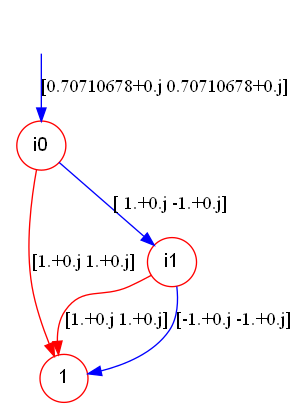

In [7]:
U = 1/np.sqrt(2)*np.array([[[1,1],[1,-1]],[[1,1],[-1,1]]])
U_tdd = tdd.as_tensor((U,[2],[]))

U_tdd.show(full_output=True)

node weight demonstration

tensor([[[ 0.707106781186547,  0.000000000000000],
         [ 0.707106781186547,  0.000000000000000]],

        [[ 0.707106781186547,  0.000000000000000],
         [-0.707106781186547,  0.000000000000000]]], dtype=torch.float64)


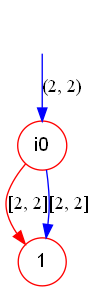

In [8]:
U = 1/np.sqrt(2)*np.array([[[1,1],[1,-1]],[[1,1],[-1,1]]])
U_tdd = tdd.as_tensor((U,[2,2],[]))

print(U_tdd.weights)
U_tdd.show()

#### Demonstration of tdd's infimum type

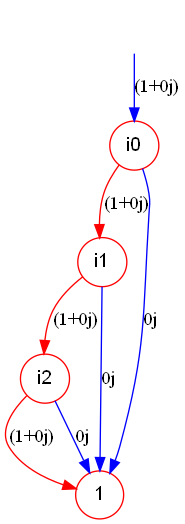

In [9]:
U = np.zeros((2,2,2))
U[0,0,0] = 1

U_tdd = tdd.as_tensor(U)
U_tdd.show()


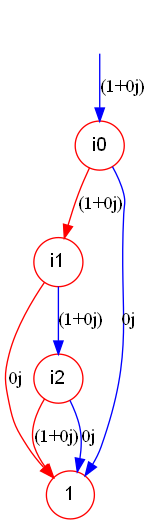

In [10]:
U = np.zeros((2,2,2))
U[0,1,0] = 1

U_tdd = tdd.as_tensor(U)
U_tdd.show()


the result of stack them together

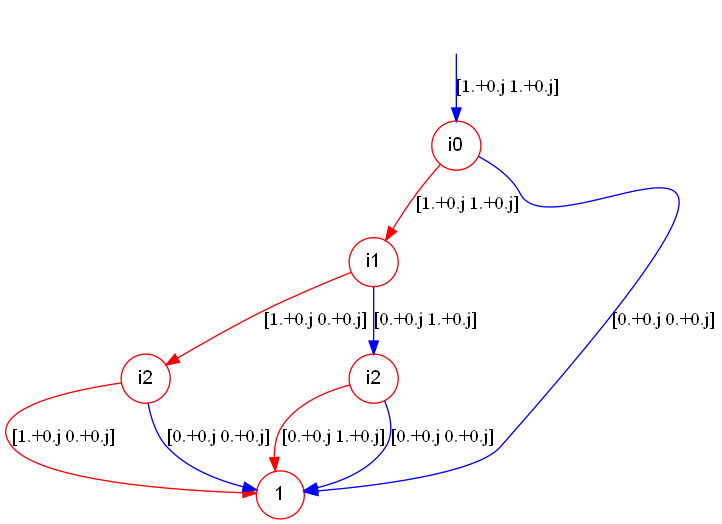

In [11]:
U1 = np.zeros((2,2,2))
U2 = np.zeros((2,2,2))
U1[0,0,0] = 1
U2[0,1,0] = 1

U_tdd = tdd.as_tensor((np.stack((U1,U2)),[2],[]))
U_tdd.show(full_output=True)

### indexing (slicing)

np result:
[[[[ 0.35355339  0.35355339]
   [ 0.35355339  0.35355339]]

  [[ 0.35355339 -0.35355339]
   [ 0.35355339 -0.35355339]]]


 [[[-0.35355339 -0.35355339]
   [-0.35355339 -0.35355339]]

  [[-0.35355339  0.35355339]
   [-0.35355339  0.35355339]]]]
tdd result:
[[[[ 0.35355339+0.j  0.35355339+0.j]
   [ 0.35355339+0.j  0.35355339+0.j]]

  [[ 0.35355339+0.j -0.35355339+0.j]
   [ 0.35355339+0.j -0.35355339+0.j]]]


 [[[-0.35355339+0.j -0.35355339+0.j]
   [-0.35355339+0.j -0.35355339+0.j]]

  [[-0.35355339+0.j  0.35355339+0.j]
   [-0.35355339+0.j  0.35355339+0.j]]]]


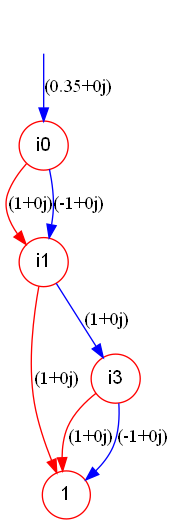

In [12]:
U = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U_tensor = np.einsum('ab,cd,ef->acebdf', U, U, U)

print('np result:')
print(U_tensor[:,0,:,1,...])

U_tdd = tdd.as_tensor((U_tensor,[],[0,3,1,4,2,5]))
U_tdd = U_tdd.index([(1,0),(3,1)])

print('tdd result:')
print(U_tdd.numpy())
U_tdd.show()

### tensordot

example1

np result:
[[1. 0.]
 [0. 1.]]
tdd result:
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


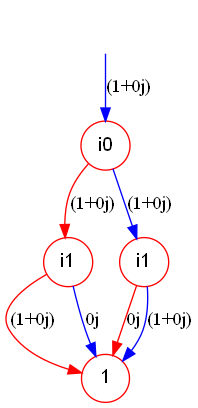

In [13]:
U=1/np.sqrt(2)*np.array([[1,1],[1,-1]])

print('np result:')
print(np.tensordot(U, U, 1))

print('tdd result:')
U_tdd=tdd.as_tensor((U,[],[1,0]))
tdd_dot = tdd.tensordot(U_tdd,U_tdd,1)

print(tdd_dot.numpy())
tdd_dot.show()

example2

np result:
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
tdd result:
[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]


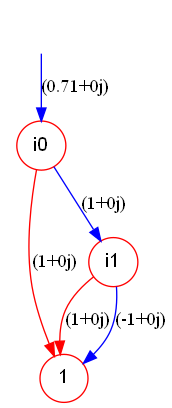

In [14]:
U=1/np.sqrt(2)*np.array([[1,1],[1,-1]])

print('np result:')
print(U @ U @ U)

print('tdd result:')
U_prod = np.einsum('ab,cd,ef->acebdf',U,U,U)
U_tdd=tdd.as_tensor((U_prod,[],[0,1,3,4,2,5]))
tdd_dot = U_tdd.contract([[1,3],[2,4]])

print(tdd_dot.numpy())
tdd_dot.show()